In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')        

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

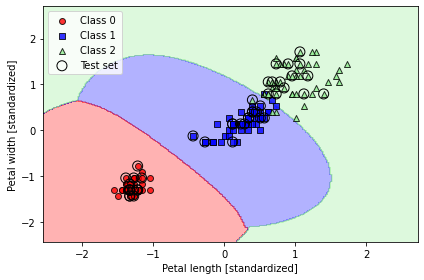

In [6]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma='scale', C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## K-fold-stratified

In [7]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train_std, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    svm.fit(X_train_std[train], y_train[train])
    score = svm.score(X_train_std[test], y_train[test])
    scores.append(score)

    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')
    
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [31 31 32], Acc.: 1.000
Fold: 02, Class distr.: [31 31 32], Acc.: 1.000
Fold: 03, Class distr.: [31 31 32], Acc.: 1.000
Fold: 04, Class distr.: [31 31 32], Acc.: 1.000
Fold: 05, Class distr.: [31 31 32], Acc.: 1.000
Fold: 06, Class distr.: [32 32 31], Acc.: 1.000
Fold: 07, Class distr.: [32 32 31], Acc.: 0.800
Fold: 08, Class distr.: [32 32 31], Acc.: 0.900
Fold: 09, Class distr.: [32 32 31], Acc.: 0.900
Fold: 10, Class distr.: [32 32 31], Acc.: 0.900

CV accuracy: 0.950 +/- 0.067


## Learning curve

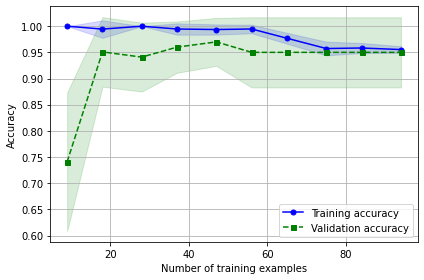

In [8]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=svm,
                               X=X_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Validation curve

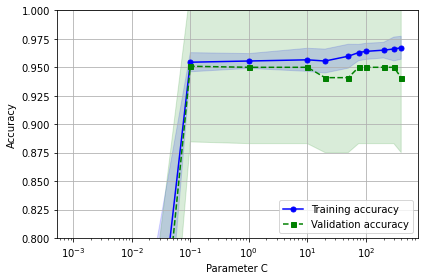

In [9]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 75.0, 100.0, 200.0, 300.0, 400.0]
train_scores, test_scores = validation_curve(
                estimator=svm, 
                X=X_train_std, 
                y=y_train, 
                param_name='C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## Grid search

In [10]:
from sklearn.model_selection import GridSearchCV

param_range_C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 100.0, 200.0, 500.0, 1000.0]
param_range_gamma = ['scale', 'auto']

param_grid = [{'C': param_range_C, 
               'kernel': ['linear']},
              {'C': param_range_C, 
               'gamma': param_range_gamma, 
               'kernel': ['rbf']}]

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10)
gs = gs.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9509090909090909
{'C': 0.1, 'kernel': 'linear'}


## Randomized Search

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

param_range_C = scipy.stats.loguniform(0.0001, 1000.0)

param_range_gamma = ['scale', 'auto']

param_grid = [{'C': param_range_C, 
               'kernel': ['linear']},
              {'C': param_range_C, 
               'gamma': param_range_gamma, 
               'kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=svm,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=100,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train_std, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9609090909090909
{'C': 0.051924842528700964, 'kernel': 'linear'}


## Confusion matrix

[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]


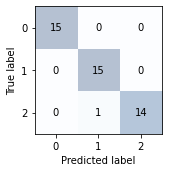

In [12]:
from sklearn.metrics import confusion_matrix

svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

# XOR

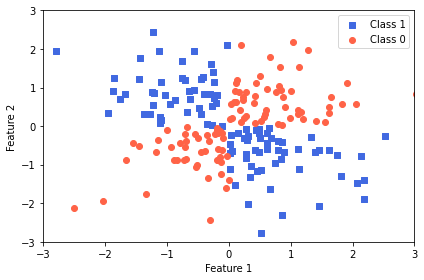

In [13]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

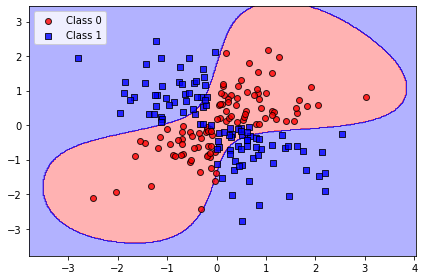

In [14]:
svm = SVC(kernel='rbf', random_state=1, gamma='scale', C=0.01)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

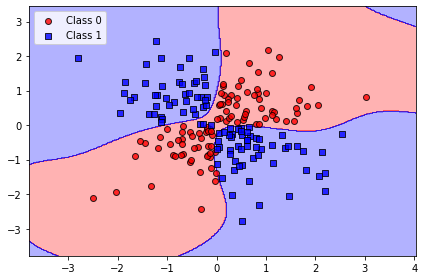

In [15]:
svm = SVC(kernel='rbf', random_state=1, gamma='scale', C=20.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

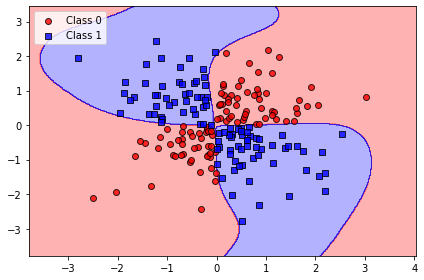

In [16]:
svm = SVC(kernel='rbf', random_state=1, gamma='scale', C=900.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## K-fold-stratified XOR

In [17]:
from sklearn.model_selection import StratifiedKFold

svm = SVC(kernel='rbf', random_state=1, gamma='scale', C=20.0)

kfold = StratifiedKFold(n_splits=10).split(X_xor, y_xor)

scores = []
for k, (train, test) in enumerate(kfold):
    svm.fit(X_xor[train], y_xor[train])
    score = svm.score(X_xor[test], y_xor[test])
    scores.append(score)

    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_xor[train])}, '
          f'Acc.: {score:.3f}')
    
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [90 90], Acc.: 1.000
Fold: 02, Class distr.: [90 90], Acc.: 0.950
Fold: 03, Class distr.: [90 90], Acc.: 0.900
Fold: 04, Class distr.: [90 90], Acc.: 0.950
Fold: 05, Class distr.: [90 90], Acc.: 0.900
Fold: 06, Class distr.: [90 90], Acc.: 1.000
Fold: 07, Class distr.: [90 90], Acc.: 1.000
Fold: 08, Class distr.: [90 90], Acc.: 1.000
Fold: 09, Class distr.: [90 90], Acc.: 0.900
Fold: 10, Class distr.: [90 90], Acc.: 0.900

CV accuracy: 0.950 +/- 0.045


## Learning curve XOR

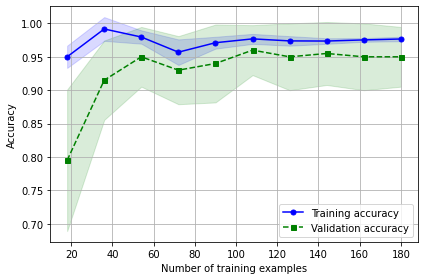

In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=svm,
                               X=X_xor,
                               y=y_xor,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Validation curve XOR

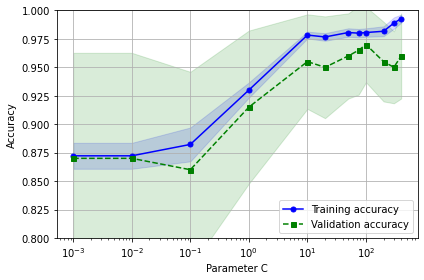

In [19]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 75.0, 100.0, 200.0, 300.0, 400.0]
train_scores, test_scores = validation_curve(
                estimator=svm, 
                X=X_xor, 
                y=y_xor, 
                param_name='C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## Grid search

In [20]:
from sklearn.model_selection import GridSearchCV

param_range_C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 100.0, 200.0, 500.0, 1000.0]
param_range_gamma = ['scale', 'auto']

param_grid = [{'C': param_range_C, 
               'kernel': ['linear']},
              {'C': param_range_C, 
               'gamma': param_range_gamma, 
               'kernel': ['rbf']}]

gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10)
gs = gs.fit(X_xor, y_xor)
print(gs.best_score_)
print(gs.best_params_)

0.97
{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}


## Randomized Search

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

param_range_C = scipy.stats.loguniform(0.0001, 1000.0)

param_range_gamma = ['scale', 'auto']

param_grid = [{'C': param_range_C, 
               'kernel': ['linear']},
              {'C': param_range_C, 
               'gamma': param_range_gamma, 
               'kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=svm,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=100,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_xor, y_xor)
print(rs.best_score_)
print(rs.best_params_)

0.97
{'C': 113.53813701628445, 'gamma': 'auto', 'kernel': 'rbf'}


## Confusion matrix

[[99  1]
 [ 3 97]]


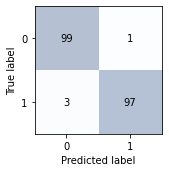

In [22]:
from sklearn.metrics import confusion_matrix

svm.fit(X_xor, y_xor)
y_pred = svm.predict(X_xor)
confmat = confusion_matrix(y_true=y_xor, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

$$Precision$$
$$PRE=\frac{TP}{TP+FP}$$

$$Recall$$
$$REC=\frac{TP}{FN+TP}$$

$$F1$$
$$F1=2\frac{PRExREC}{PRE+REC}$$

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_xor, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_xor, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_xor, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_xor, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.990
Recall: 0.970
F1: 0.980
MCC: 0.960


## ROC receiver operating characteristic

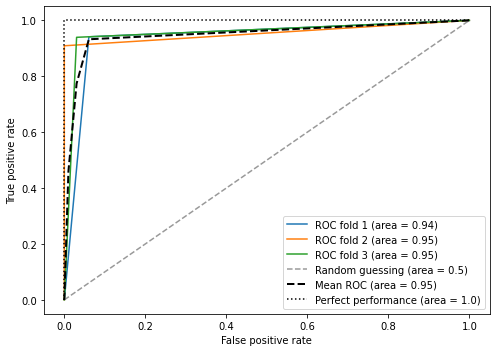

In [29]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

cv = list(StratifiedKFold(n_splits=3).split(X_xor, y_xor))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = svm.fit(X_xor[train],
                         y_xor[train]).predict(X_xor[test])

    fpr, tpr, thresholds = roc_curve(y_xor[test],
                                     probas,
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area = 0.5)')


mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()